Dans cet notebook, nous abordons les statistiques descriptives sur les incidents de sécurité sur le réseau de la SCNF

In [33]:
####################### Paramétrage du notebook ##################################
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [143]:
############ Importation des modules nécessaires et du jeu de données ##############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime  #pour la gestion des dates
import requests
url_api="https://ressources.data.sncf.com/api/v2/catalog/datasets/incidents-securite/exports/json?limit=-1&offset=0&lang=fr&timezone=Europe%2FParis"
incident= requests.get(url_api).json()
incident=pd.json_normalize(incident)
#incident.head()


In [204]:
######## Retrait des données de 2015 ###########
incident['annee']=incident['date'].dt.strftime('%Y')
incident2=incident.drop(incident[incident['annee']=="2015"].index, inplace=False)

,id,origine,numero_isic,type_event,date,nature,region,lieu,niveau_gravite,annee
66,None,None,None,None,NaT,Blanc = ESR Autre,None,None,NaN,NaN
67,21649,Cause Tiers Réseau,19910,Déraillement,2016-01-14,[a] Collision du train 49200 avec un camion au...,LOR,Beuveille,4.0,2016
68,21673,Mobilités,None,Portes ouvertes sur train de voyageurs en circ...,2016-01-16,[m] Porte ouverte en ligne sur train N° 17763 ...,BFC,Entre Laroche-Migennes & St-Florentin-Vergigny,3.0,2016
69,21734,Mobilités,None,Portes ouvertes sur train de voyageurs en circ...,2016-01-21,[m] Porte ouvertes en ligne signalée par un vo...,AL,Mundolsheim,3.0,2016
70,22031,Réseau,None,Expédition d'un train sans ordre écrit de res...,2016-02-04,[r] Dépassement de vitesse supérieur à 40 km/h...,PSE,Ferrières Fontenay,4.0,2016
...,...,...,...,...,...,...,...,...,...,...
1646,None,Fret,None,FCollision contre obstacle à un passage à niveau,2022-07-14,Un incendie s'est déclaré après le passage d'u...,PACA,Barbentane (13),5.0,2022
1647,None,Réseau,None,Expédition d'un train sans ordre écrit de res...,2022-08-11,Un AC (Agent Circulation) constate le décontrô...,PN,Montigny Beauchamp (93),4.0,2022
1648,None,Réseau,None,Défaillance voie,2022-08-30,Découverte de défauts de géométrie imposant l'...,GE,Strasbourg,4.0,2022
1649,None,Réseau,None,Défaillance voie,2022-09-15,Défauts de géométrie sur Voie Principale impos...,GE,Hagondange (57),4.0,2022


## En moyenne, sur la période de 2016 à 2022, quelles sont les régions dans lesquelles les incidents sont les plus graves? 💡

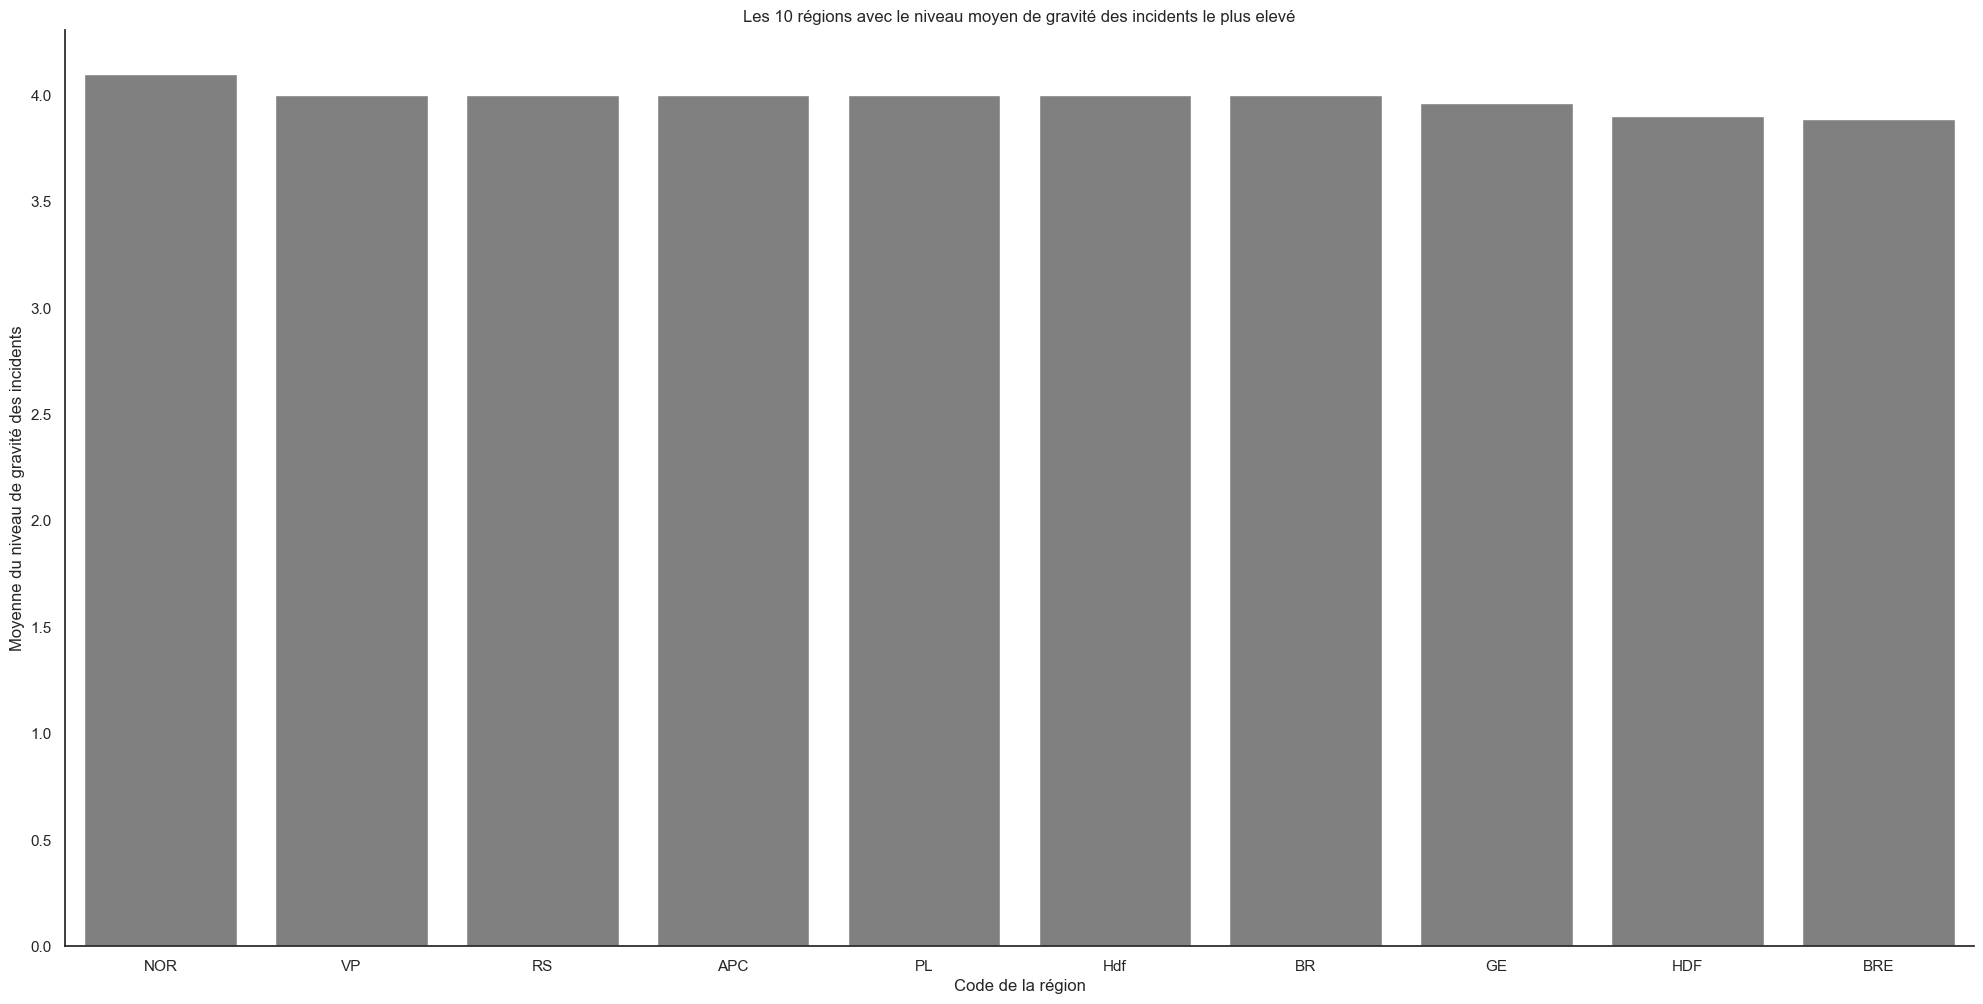

In [182]:
df1=incident2.groupby('region').agg({'niveau_gravite': "mean"}).sort_values('niveau_gravite', ascending = False).head(10)
df1=df1.reset_index()
#sns.set(style="darkgrid")
g = sns.catplot(x='region', y='niveau_gravite', data=df1, kind = "bar", height = 10, aspect = 2, color='gray')
g.set_axis_labels('Code de la région', 'Moyenne du niveau de gravité des incidents')
plt.title('Les 10 régions avec le niveau moyen de gravité des incidents le plus elevé')
plt.show()

## Comment sont répartis les incidents survenus par année?

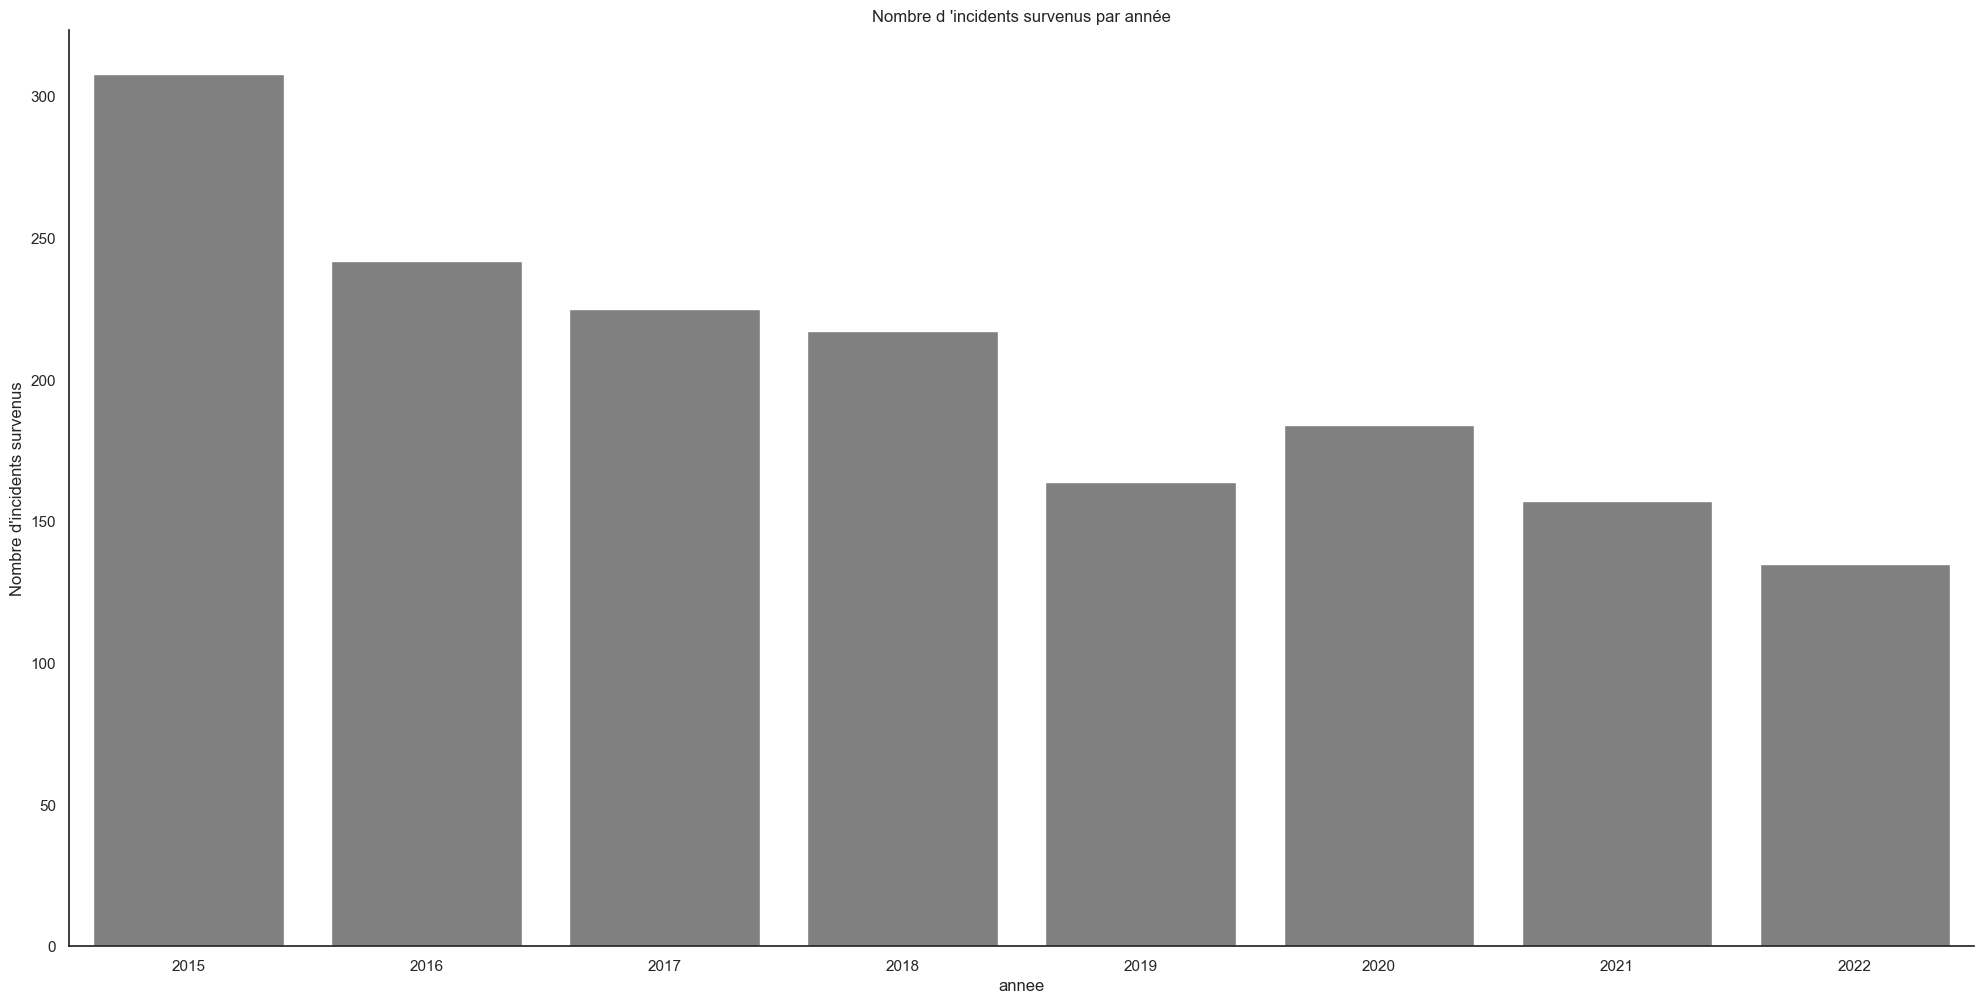

In [183]:
df2=incident.groupby('annee').agg({'annee': "count"})
df2.rename(columns = {'annee':'occurence'}, inplace = True)
df2=df2.reset_index()
g1 = sns.catplot(x='annee', y='occurence', data=df2, kind = "bar", height = 10, aspect = 2, color='gray')
g1.set_axis_labels('annee', 'Nombre d\'incidents survenus')
plt.title('Nombre d \'incidents survenus par année')
plt.show()

## Evolution du niveau moyen de gravité des incidents survenus depuis 2016

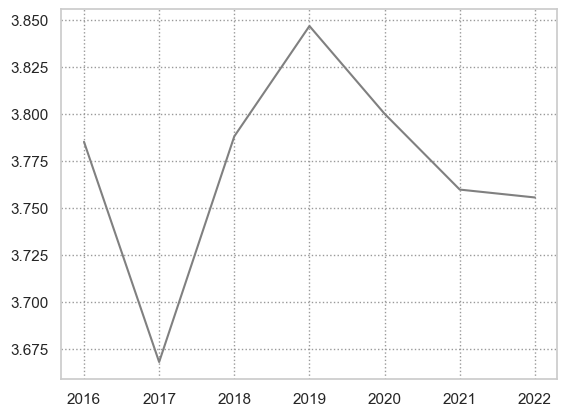

In [202]:
df3=incident2.groupby('annee').agg({'niveau_gravite': "mean"})
df3=df3.reset_index()
sns.set_style("whitegrid",{"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(df3['annee'], df3['niveau_gravite'], "gray")